In [1]:
import random as rd
import numpy as np
from time import time
import matplotlib.pyplot as plt

In [2]:
class site:
    def __init__(self,lattice,x,y,z):
        self.x = x
        self.y = y
        self.z = z
        self.lattice = lattice

    def setspin(self,s):
        self.spin = s
    
    def setrandomspin(self): # set random spin for this site
        self.spin = rd.choice([-1,1]) # set spin = -1 or 1
     
    def getspin(self):
        return self.spin

    def flipspin(self):
        self.spin *= -1

    def getposition(self):
        return np.array([self.x,self.y,self.z])

    def getzeemanenergy(self,B):
        g = 2.0
        muB = 5e-2 #mev/T
        return -g*muB*self.getspin()*B

    def getdeltaexchangeenergy(self,J):
        E = 0
        NN = self.getnearestneighbourscubic()
        for nn in NN:
            E += -J*self.spin*nn.spin
        return E
    
    def getdeltaenergy(self,J,g,muB,B):
        E = 0
        NN = self.getnearestneighbourscubic()
        for nn in NN:
            E += -J*self.spin*nn.spin
        E += g*muB*B*self.spin
        E = E*2
        return E
    
    
    def getlistposition(self,x,y,z):
        return x*self.lattice.N2*self.lattice.N3 + y*self.lattice.N3 + z

    def getnearestneighbourscubic(self):
        #i-1 i+1, j-1 j+1, k-1 k+1 with periodic boundary conditions
        NN1 = self.lattice.sites[self.getlistposition((self.x-1) % self.lattice.N1, self.y, self.z)]
        NN2 = self.lattice.sites[self.getlistposition((self.x+1) % self.lattice.N1, self.y, self.z)]
        NN3 = self.lattice.sites[self.getlistposition(self.x, (self.y-1) % self.lattice.N1, self.z)]
        NN4 = self.lattice.sites[self.getlistposition(self.x, (self.y+1) % self.lattice.N1, self.z)]
        NN5 = self.lattice.sites[self.getlistposition(self.x, self.y, (self.z-1) % self.lattice.N1)]
        NN6 = self.lattice.sites[self.getlistposition(self.x, self.y, (self.z+1) % self.lattice.N1)]
        return [NN1,NN2,NN3,NN4,NN5,NN6]

In [42]:
class lattice:
    def __init__(self,N1,N2,N3):
        self.N1 = N1 # Dimension of the lattice
        self.N2 = N2
        self.N3 = N3
        self.sites = [] # Creating a list to take in the information of sites

    def getnumberofsites(self):
        return self.N1*self.N2*self.N3
    
    def populatesites(self,lat):
        for i in range(self.N1):
            for j in range(self.N2):
                for k in range(self.N3):
                    self.sites.append(site(lat,i,j,k)) # Assign each site a coordianate

    def initialisespins(self): # Set spin for each site
        for i in range(self.N1*self.N2*self.N3):
            self.sites[i].setrandomspin()

    def getlistposition(self,x,y,z):
        return x*self.N2*self.N3 + y*self.N3 + z
            
    def gettotalenergy1(self,J):
        E = 0 #meV
        for i in range(self.N1):
            for j in range(self.N2):
                for k in range(self.N3):
                    E += -J*self.sites[self.getlistposition(i, j, k)].getspin() * self.sites[self.getlistposition(i, j, (k+1)% self.N3)].getspin()
        
        for i in range(self.N1):
            for k in range(self.N3):
                for j in range(self.N2):
                    E += -J*self.sites[self.getlistposition(i, j, k)].getspin() * self.sites[self.getlistposition(i, (j+1)% self.N2, k)].getspin()
                
        for j in range(self.N2):
            for k in range(self.N3):
                for i in range(self.N1):
                    E += -J*self.sites[self.getlistposition(i, j, k)].getspin() * self.sites[self.getlistposition((i+1)% self.N1, j, k)].getspin()
                
        return E
    
    def getenergypersite(self,J,g,muB,B):
        E = 0 #meV

        for i in range(self.N1):
            for j in range(self.N2):
                for k in range(self.N3):
                    E += -J*self.sites[self.getlistposition(i, j, k)].getspin() * self.sites[self.getlistposition(i, j, (k+1)% self.N3)].getspin()
                    E += g*muB*B*self.sites[self.getlistposition(i, j, k)].getspin()
                    
        for i in range(self.N1):
            for k in range(self.N3):
                for j in range(self.N2):
                    E += -J*self.sites[self.getlistposition(i, j, k)].getspin() * self.sites[self.getlistposition(i, (j+1)% self.N2, k)].getspin()

        for j in range(self.N2):
            for k in range(self.N3):
                for i in range(self.N1):
                    E += -J*self.sites[self.getlistposition(i, j, k)].getspin() * self.sites[self.getlistposition((i+1)% self.N1, j, k)].getspin()
    
        return E/(self.N1*self.N2*self.N3)
    
    def pickrandomsite(self):
        site_f = rd.randrange(self.N1*self.N2*self.N3)
        return site_f
    
    def filpspin(self,site_f):
        self.sites[site_f].flipspin()
        
    def getmagnetization(self):
        M = 0
        for i in range(self.N1):
            for j in range(self.N2):
                for k in range(self.N3):
                    M += -self.sites[self.getlistposition(i, j, k)].getspin()
        return M/(self.N1*self.N2*self.N3)

In [67]:
starttime = time()

MCS = 1000 # MC steps per temperature
J = 50 # meV
T = 500 # Kelvin
T_p = 0.97
kB = 8.617e-2 # meV/K
g = 1
muB = 5.788e-2 #meV/T
B = 10 #T

MCA_plot_1 = []
T_plot_1 = []
E_plot_1 = []
Mag_plot_1 = []

# set up the sites
lat1 = lattice(40,40,40) # set up the size of lattice
lat1.populatesites(lat1)     # Assign each site a coordinate
lat1.initialisespins()   # Assign each site a random spin
E_i = lat1.getenergypersite(J,g,muB,B) # get initial energy per site of the system
E_1 = E_i

NoS = lat1.getnumberofsites()

while (T>0.05):
    
    MCA = 0    # Initialise MC accepts
    Mag_1 = 0  # Initialise Magnetization
    for i in range(MCS):
        fs = lat1.pickrandomsite() # pick a random site to flip its spin
        lat1.filpspin(fs) # flip spin
        dE = lat1.sites[fs].getdeltaenergy(J,g,muB,B)
        

        if dE <= 0 or np.exp(-dE/(kB*T)) > rd.random():
            E_1 += dE/NoS
            MCA += 1 # MC Accepts
            
        else:
            lat1.filpspin(fs) # flip the spin back
    
    Mag_1 = lat1.getmagnetization() # magnetization of the system
    
    MCA_plot_1.append(MCA)
    T_plot_1.append(T)
    E_plot_1.append(E_1)
    Mag_plot_1.append(Mag_1)
    
    T = T_p * T
    
print ("Runtime:  %.6f"  %(time()-starttime))

Runtime:  9.726673


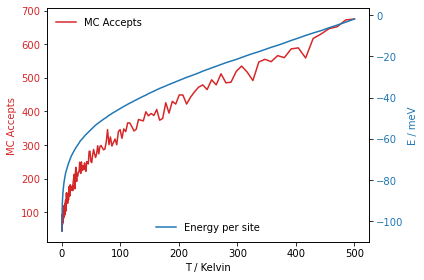

In [68]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('T / Kelvin')
ax1.set_ylabel('MC Accepts', color=color)
ax1.plot(T_plot_1,MCA_plot_1, color=color, label="MC Accepts")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc="best",frameon=False)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('E / meV', color=color)  # we already handled the x-label with ax1
ax2.plot(T_plot_1,E_plot_1, color=color, label="Energy per site")
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc="lower center",frameon=False)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [69]:
print(kB/muB)

1.4887698686938493


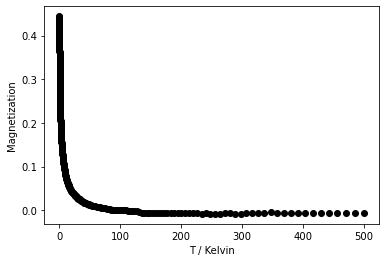

In [70]:
plt.close('all')
plt.figure()
plt.plot(T_plot_1,Mag_plot_1,'ok')
#plt.gca().invert_xaxis()
plt.xlabel('T / Kelvin')
plt.ylabel('Magnetization')
#plt.xlim([1,0])
plt.show()

In [7]:
starttime = time()

MCS = 1000 # MC steps per temperature
J = 5 # MeV
T = 500 # Kelvin
T_p = 0.97
kB = 8.617e-2 # MeV/K
g = 1
muB = 5.788e-2 #MeV/T
B = 1.0 #T

MCA_plot_1 = []
T_plot_1 = []
E_plot_1 = []
Mag_plot_1 = []

# set up the sites
lat1 = lattice(100,100,100) # set up the size of lattice
lat1.populatesites(lat1)     # Assign each site a coordinate
lat1.initialisespins()   # Assign each site a random spin
E_i = lat1.getenergypersite(J,g,muB,B) # get initial energy per site of the system
E_1 = E_i

NoS = lat1.getnumberofsites()

while (T>0.05):
    
    MCA = 0    # Initialise MC accepts
    Mag_1 = 0  # Initialise Magnetization
    for i in range(MCS):
        fs = lat1.pickrandomsite() # pick a random site to flip its spin
        lat1.filpspin(fs) # flip spin
        dE = lat1.sites[fs].getdeltaenergy(J,g,muB,B)/NoS
        

        if dE <= 0 or np.exp(-dE/(kB*T)) > rd.random():
            E_1 += dE
            MCA += 1 # MC Accepts
            
        else:
            lat1.filpspin(fs) # flip the spin back
    
    Mag_1 = lat1.getmagnetization()
    MCA_plot_1.append(MCA)
    T_plot_1.append(T)
    E_plot_1.append(E_1)
    Mag_plot_1.append(Mag_1)
    
    T = T_p * T
    
print ("Runtime:  %.6f"  %(time()-starttime))

Runtime:  117.370005


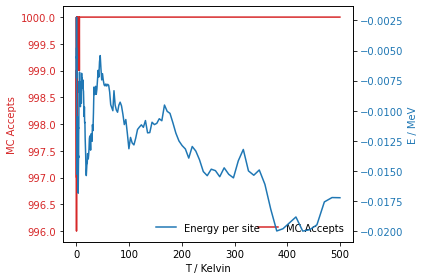

In [8]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('T / Kelvin')
ax1.set_ylabel('MC Accepts', color=color)
ax1.plot(T_plot_1,MCA_plot_1, color=color, label="MC Accepts")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc="best",frameon=False)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('E / MeV', color=color)  # we already handled the x-label with ax1
ax2.plot(T_plot_1,E_plot_1, color=color, label="Energy per site")
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc="lower center",frameon=False)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [9]:
starttime = time()

MCS = 1000 # MC steps per temperature
J = 5 # meV
T = 500 # Kelvin
T_p = 0.97
kB = 8.617e-2 # meV/K

MCA_plot_1 = []
T_plot_1 = []
E_plot_1 = []

# set up the sites
lat1 = lattice(100,100,100) # set up the size of lattice
lat1.populatesites(lat1)     # Assign each site a coordinate
lat1.initialisespins()   # Assign each site a random spin
E_0 = lat1.gettotalenergy1(J) # get initial total energy of the system
E_1 = E_0

while (T>0.05):
    
    MCA = 0    # Initialise MC accepts
    
    for i in range(MCS):
        fs = lat1.pickrandomsite() # pick a random site to flip its spin
        lat1.filpspin(fs) # flip spin
        dE = lat1.sites[fs].getdeltaexchangeenergy(J)*2

        if dE <= 0 or np.exp(-dE/(kB*T)) > rd.random():
            E_1 += dE
            MCA += 1 # MC Accepts
            
        else:
            lat1.filpspin(fs) # flip the spin back
    
    #print('%.2f  %d' %(T, MCA))
    MCA_plot_1.append(MCA)
    T_plot_1.append(T)
    E_plot_1.append(E_1)
    T = T_p * T
    
print ("Runtime:  %.6f"  %(time()-starttime))

Runtime:  6.379525


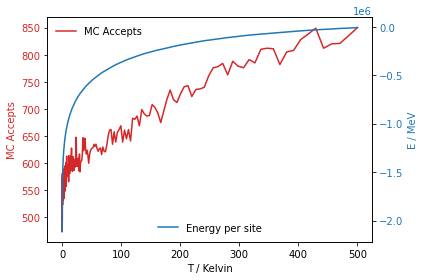

In [10]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('T / Kelvin')
ax1.set_ylabel('MC Accepts', color=color)
ax1.plot(T_plot_1,MCA_plot_1, color=color, label="MC Accepts")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc="best",frameon=False)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('E / MeV', color=color)  # we already handled the x-label with ax1
ax2.plot(T_plot_1,E_plot_1, color=color, label="Energy per site")
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc="lower center",frameon=False)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

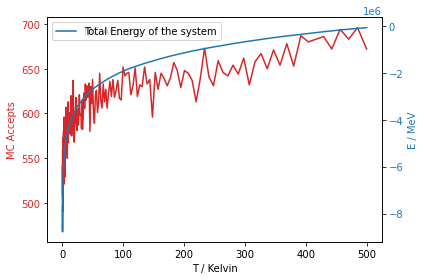

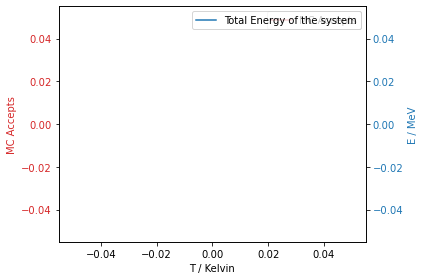

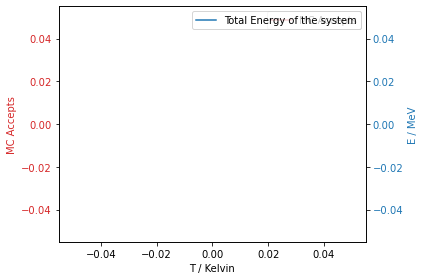

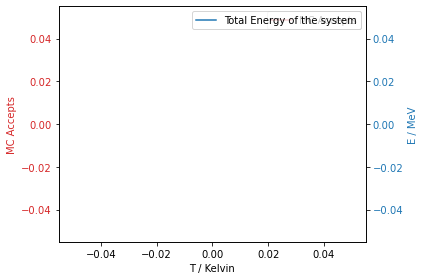

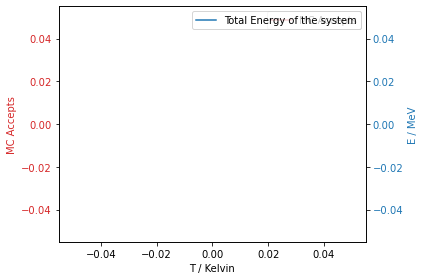

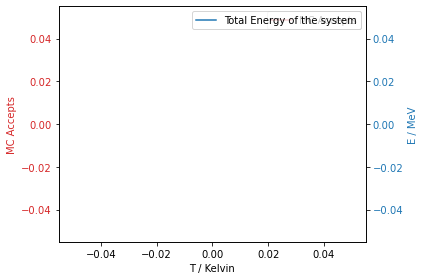

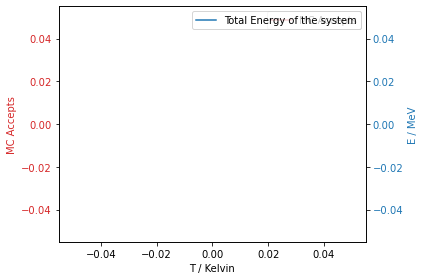

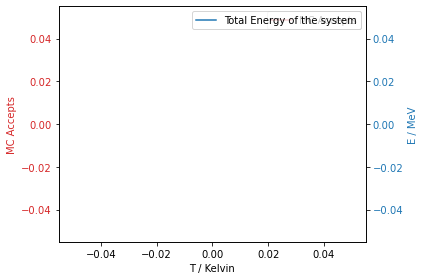

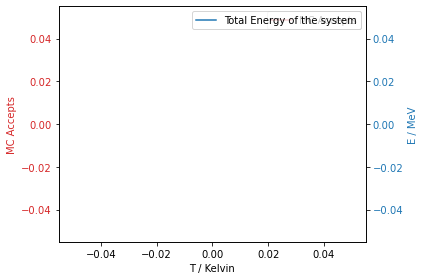

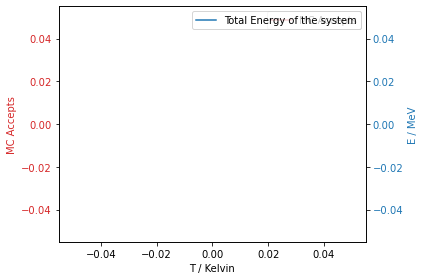

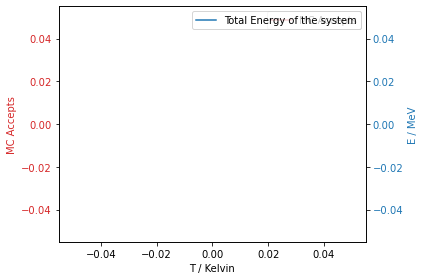

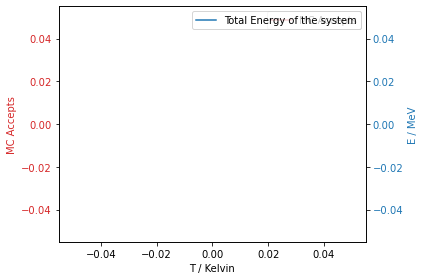

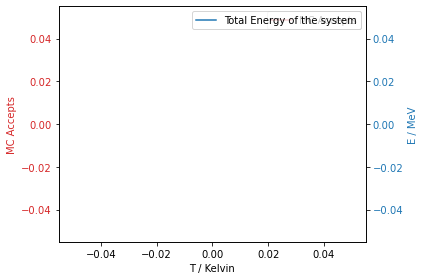

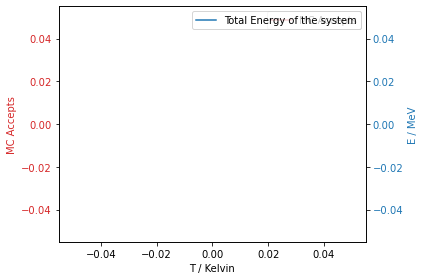

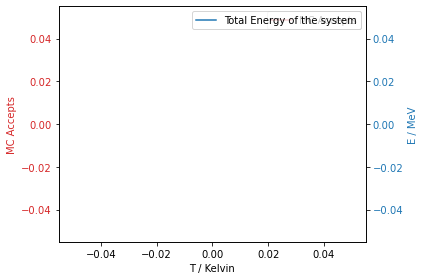

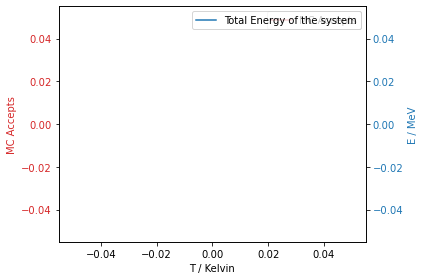

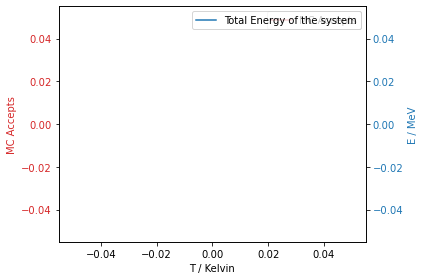

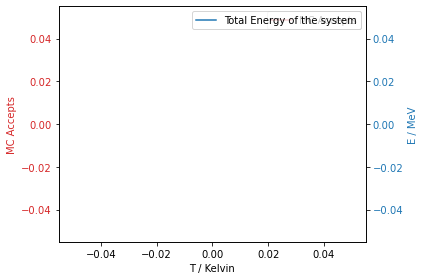

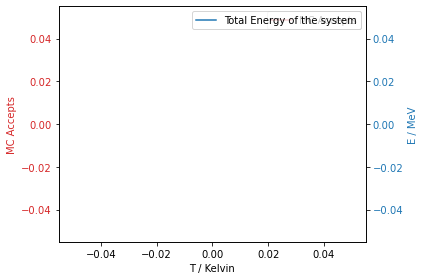

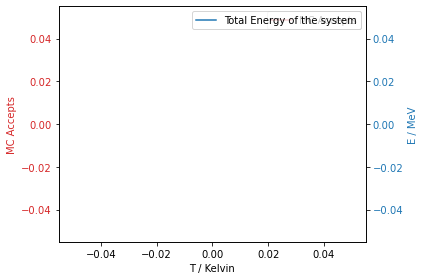

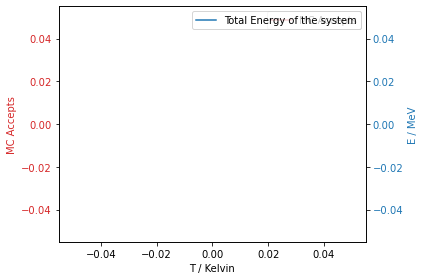

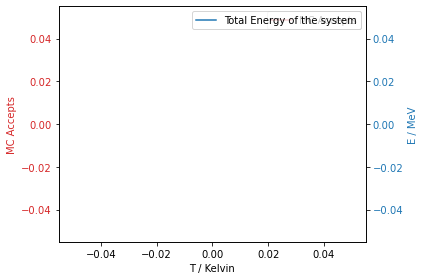

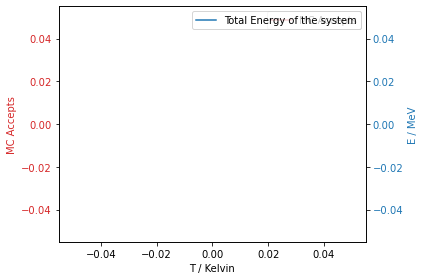

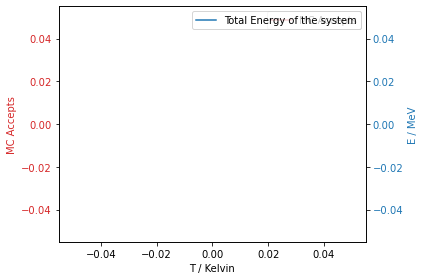

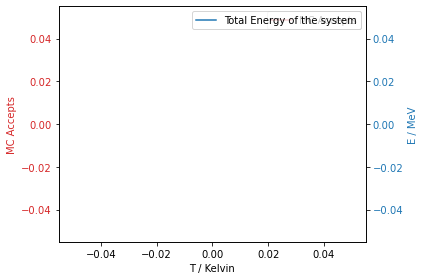

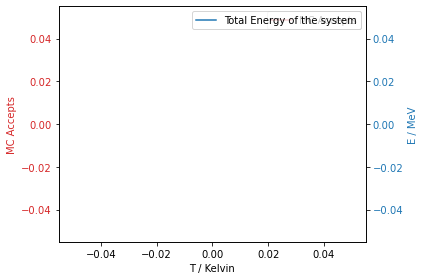

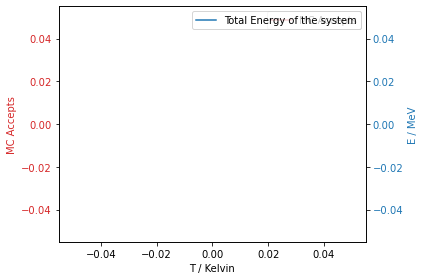

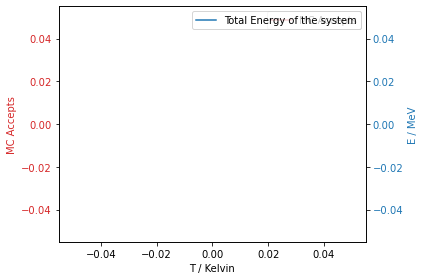

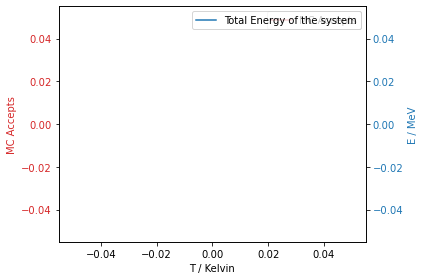

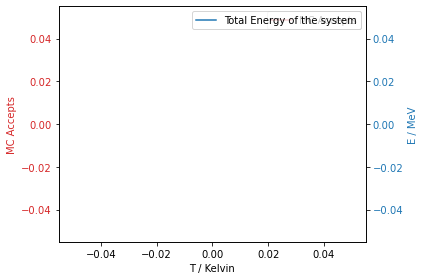

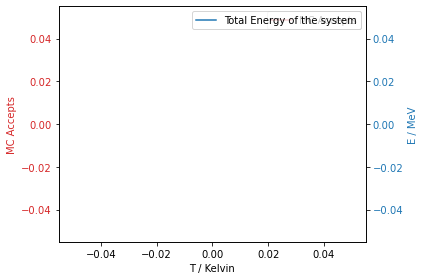

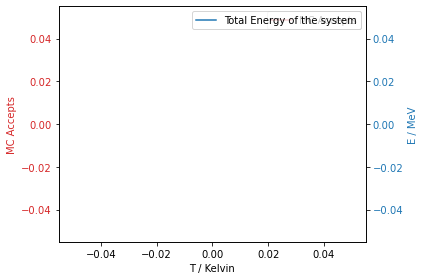

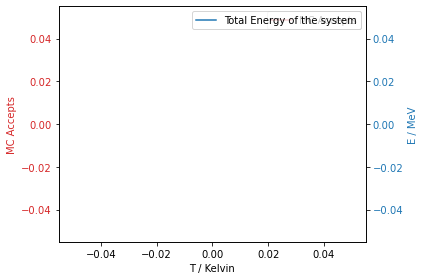

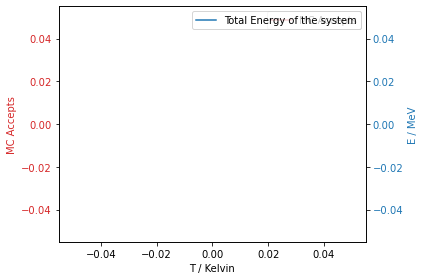

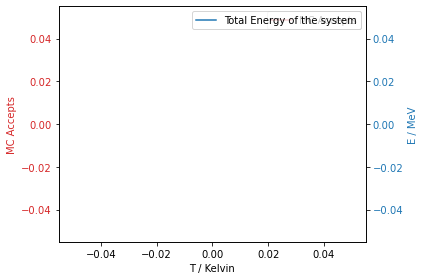

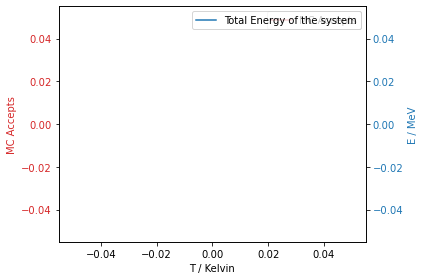

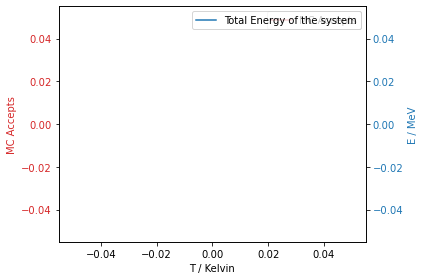

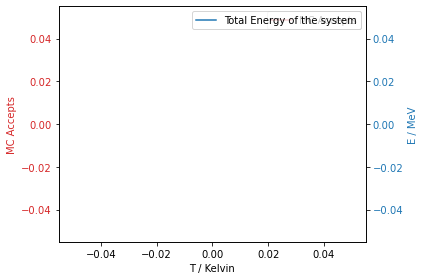

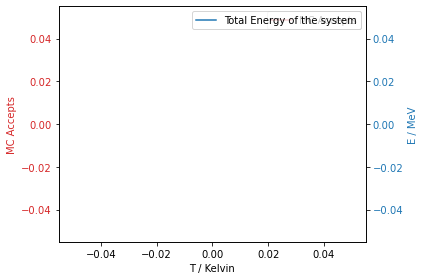

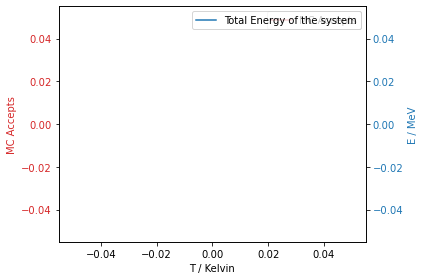

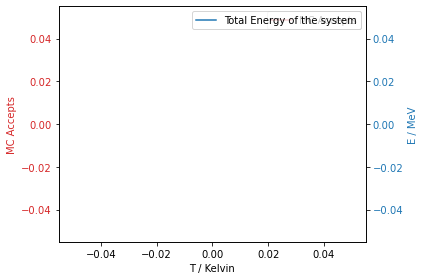

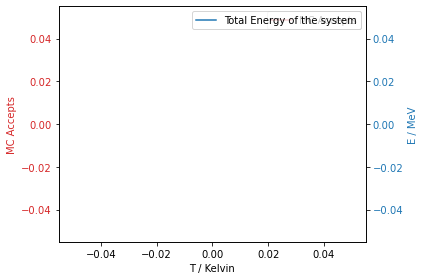

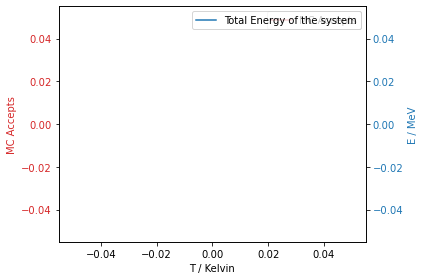

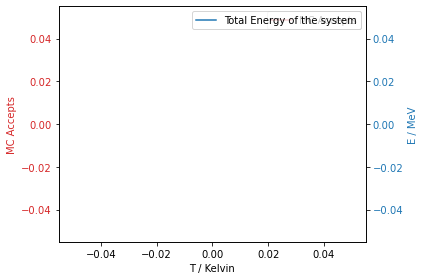

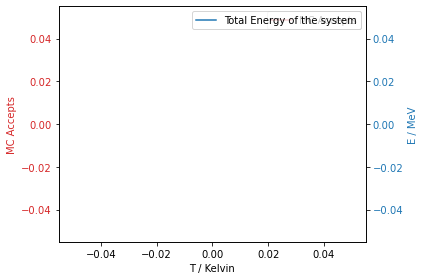

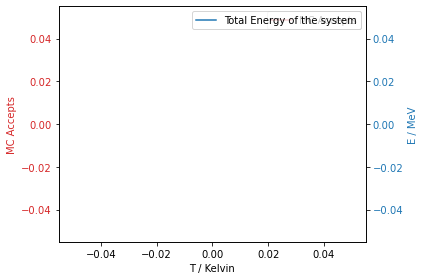

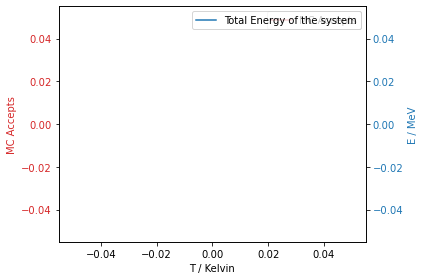

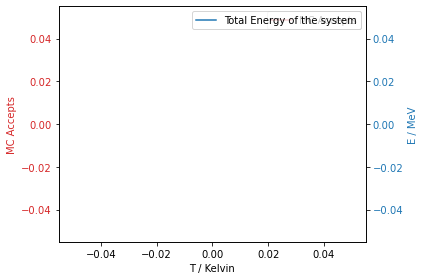

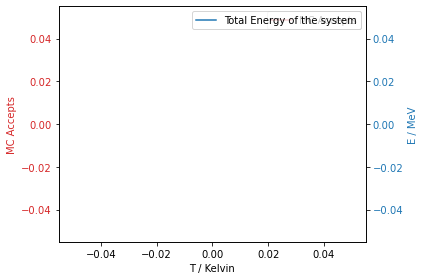

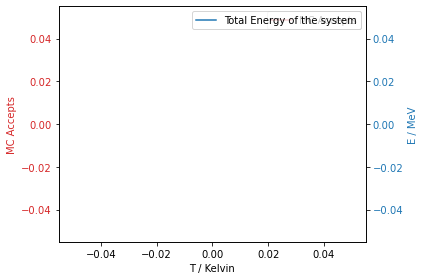

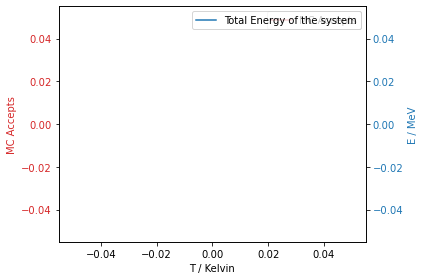

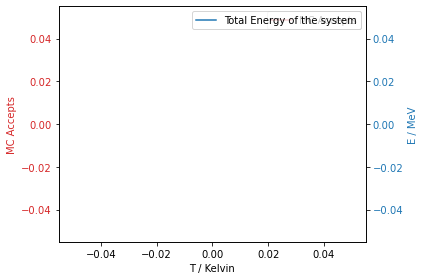

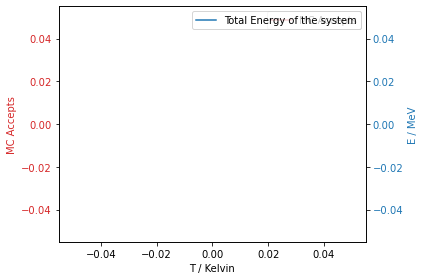

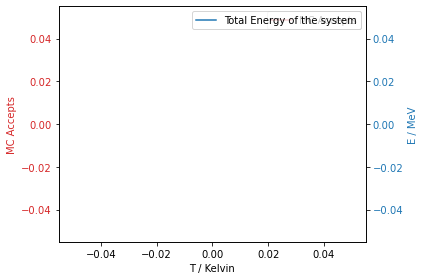

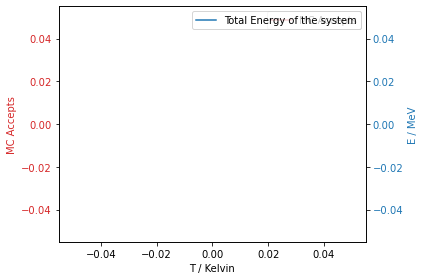

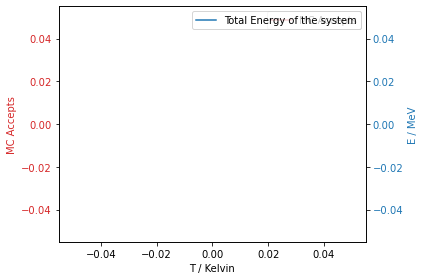

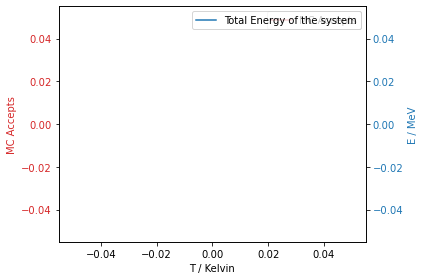

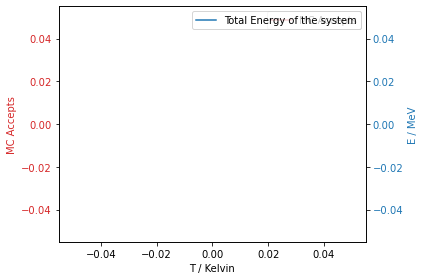

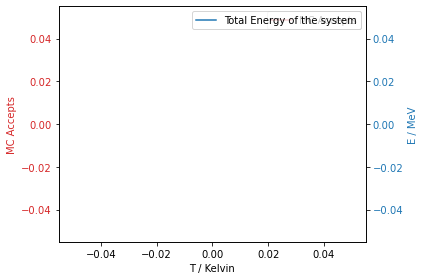

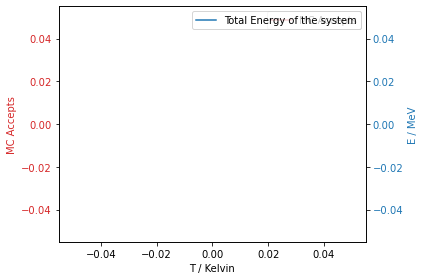

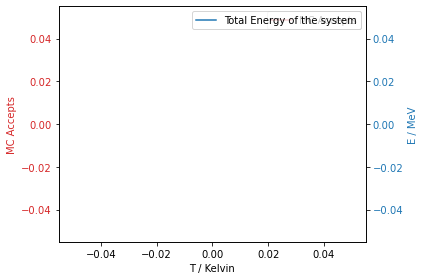

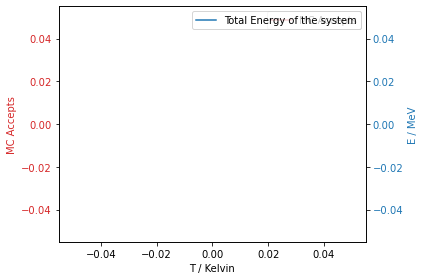

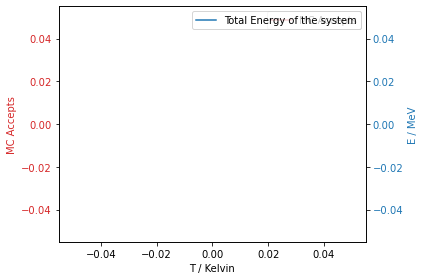

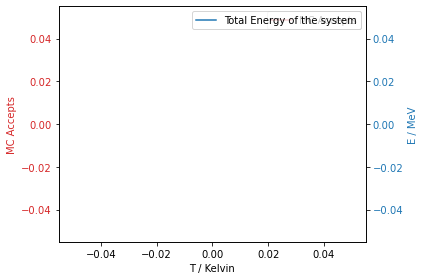

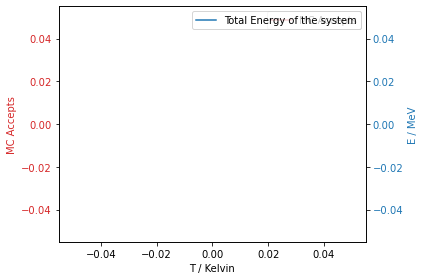

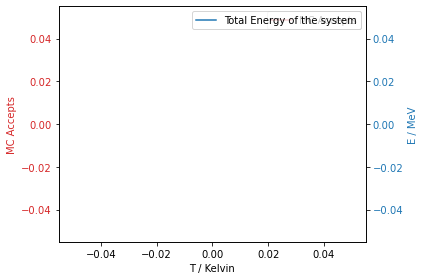

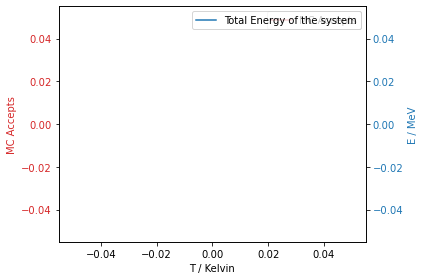

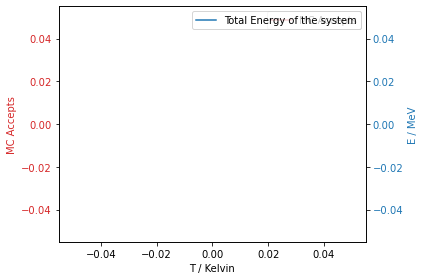

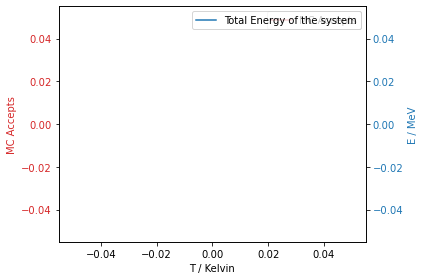

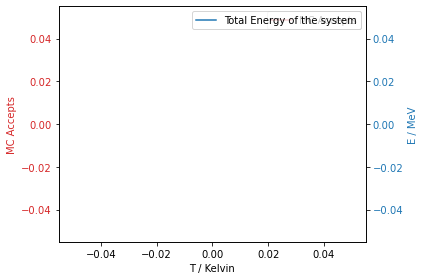

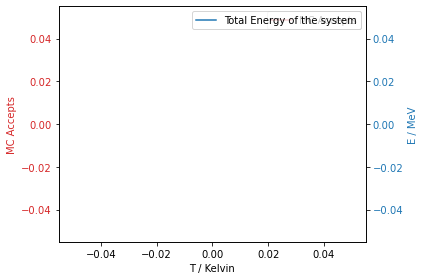

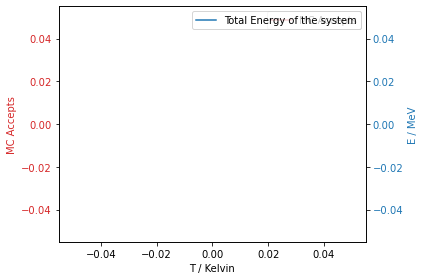

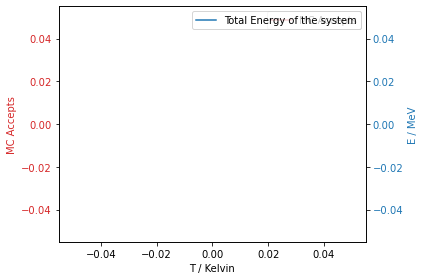

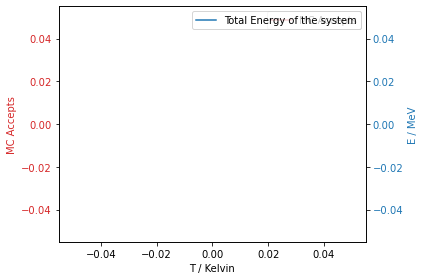

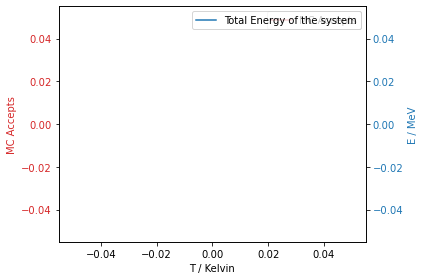

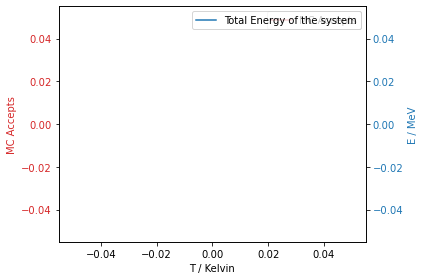

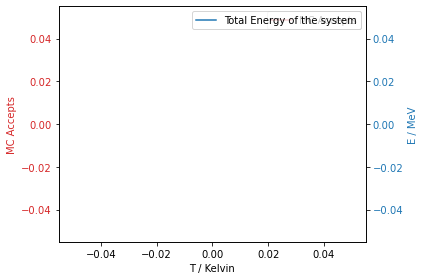

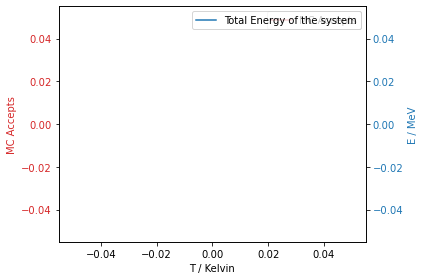

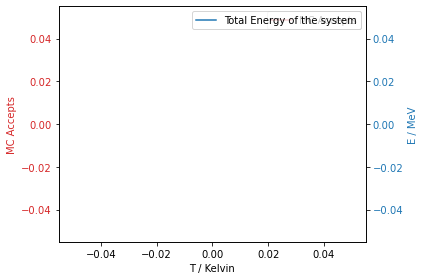

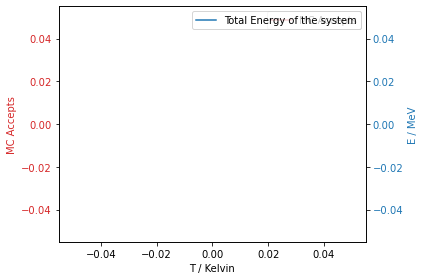

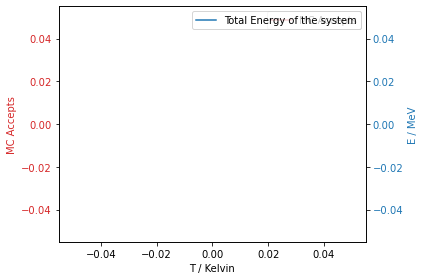

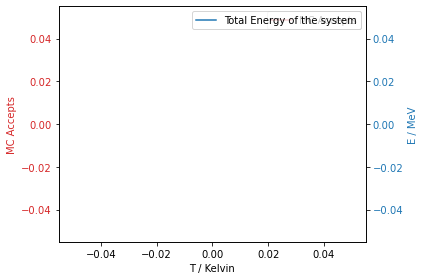

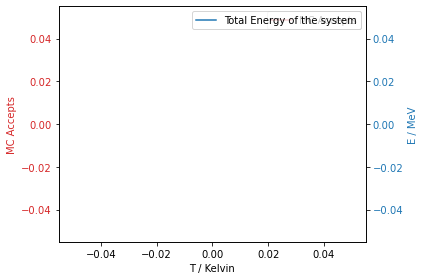

KeyboardInterrupt: 

In [11]:
J = 20 # MeV
Jstep = 0.97

MCS = 1000 # MC steps per temperature
T = 500 # Kelvin
T_p = 0.97
kB = 8.617e-2 # MeV/K
g = 1
muB = 5.788e-2 #MeV/T
B = 0.0 #T

while (J>0.05):
    MCA_plot_1 = []
    T_plot_1 = []
    E_plot_1 = []

    # set up the sites
    lat1 = lattice(100,100,100) # set up the size of lattice
    lat1.populatesites(lat1)     # Assign each site a coordinate
    lat1.initialisespins()   # Assign each site a random spin
    E_0 = lat1.gettotalenergy1(J) # get initial total energy of the system
    E_1 = E_0

    while (T>0.05):
    
        MCA = 0    # Initialise MC accepts
    
        for i in range(MCS):
            fs = lat1.pickrandomsite() # pick a random site to flip its spin
            lat1.filpspin(fs) # flip spin
            dE = lat1.sites[fs].getdeltaexchangeenergy(J)*2

            if dE <= 0 or np.exp(-dE/(kB*T)) > rd.random():
                E_1 += dE
                MCA += 1 # MC Accepts
            
            else:
                lat1.filpspin(fs) # flip the spin back
    
        MCA_plot_1.append(MCA)
        T_plot_1.append(T)
        E_plot_1.append(E_1)
        T = T_p * T

    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('T / Kelvin')
    ax1.set_ylabel('MC Accepts', color=color)
    ax1.plot(T_plot_1,MCA_plot_1, color=color, label="MC Accepts")
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc="best")
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('E / MeV', color=color)  # we already handled the x-label with ax1
    ax2.plot(T_plot_1,E_plot_1, color=color, label="Total Energy of the system")
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc="best")
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    
    J = J * Jstep